<font size="6">Архитектуры CNN</font>




# Базовые компоненты сверточных сетей



Мы рассмотрели базовые компоненты, из которых состоят современные свёрточные нейронные сети, а также техники их обучения.

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/l09.png" >

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/l09_2.png" width="760">

На этом занятии рассмотрим, какие модели для классификации изображений можно построить на основе этих компонент. 

# ImageNet Large Scale Visual Recognition Challenge

 ([ILSVRC](http://image-net.org/challenges/LSVRC/2017/))

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_2.png"  width="800"></center>
<center><em>Лучшие результаты конкнурса ILSVRC по годам.</em></center>

Загрузка с [официального сайта](http://image-net.org/download) недоступна, но можно загрузить данные с [Kaggle](https://www.kaggle.com/c/imagenet-object-localization-challenge/data). Однако архив занимает порядка 156Gb и не поместится на диск Colab. Поэтому воспользуемся другим репозиторием, в котором находится 1000 изображений из оригинального датасета.

P.S. Для загрузки данных, которые стали недоступны на официальных сайтах, можно использовать [Academic Torrents](https://academictorrents.com). В частности для [ImageNet](https://academictorrents.com/browse.php?search=imagenet).

In [1]:
import torch
import random
import numpy as np

# fix random_seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# compute in cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Full list of labels 
!wget 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
!git clone https://github.com/ajschumacher/imagen.git

zsh:1: command not found: wget
fatal: destination path 'imagen' already exists and is not an empty directory.


Загрузили категории:

In [3]:
import json
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)

with open('/Users/balepka/Yandex.Disk.localized/Study/Neural Network/imagenet_class_index.json') as f:
      imagenet_labels = json.load(f)

pp.pprint(dict(list(imagenet_labels.items())[:10])) # Use Pretty Print to display long dict

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich']}


In [4]:
from glob import glob
from PIL import Image
from torch.utils.data import Dataset

class MicroImageNet(Dataset):
  def __init__(self):
    super().__init__()
    # Load labels
    self.num2id = {}
    with open('/Users/balepka/Yandex.Disk.localized/Study/Neural Network/imagenet_class_index.json') as f:
      imagenet_labels = json.load(f)
    w_net = {}
    # Because not world net all image codes from imagen exists in imagenet_labels 
    # we need to filter this image
    for key in imagenet_labels.keys():
      wn_id = imagenet_labels[key][0]
      w_net[wn_id] = {'num': int(key), 'name': imagenet_labels[key][1] }
    self.labels = []
    self.paths = []

    # Load data
    images = glob('imagen/imagen/*.jpg')
    images.sort()
    for i, path in enumerate(images):
      name = path.split("_")[2] # Class name
      id = path.split("_")[0][14:] # WorldNet based ID
      if w_net.get(id,None): 
        self.labels.append([w_net[id]['num'], w_net[id]['name'], id])
        self.paths.append(path)
    
  def __getitem__(self,idx):
    im = Image.open(self.paths[idx])
    class_num = self.labels[idx][0]
    return im, class_num

  def __len__(self):
    return len(self.paths)


microImgNet = MicroImageNet()

Посмотрим на картинки:

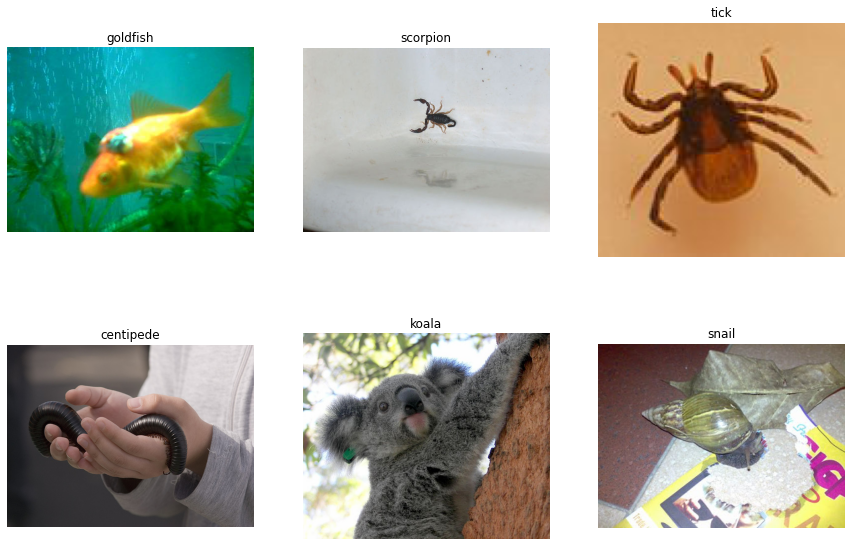

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

def show(img,label_1,num,label_2=""):
    ax = plt.subplot(2, 3,num+1)
    plt.imshow(img)
    plt.title(label_1)
    ax.set_xlabel(label_2)
    plt.axis('off')
  
for i in range(6):
  img, label = microImgNet[i*6]
  name = microImgNet.labels[i*6][1]
  show(img,name,i)

# Обзор сети AlexNet(2012 г.)

[ImageNet Classification with Deep Convolutional Neural Networks (Krizhevsky et al., 2012)](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

создатели: Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton
**University of Toronto**

Как упомяналось на первой лекции, современный бум нейростевых технологий начался в 2012 году, когда AlexNet с большим отрывом от конкурентов победила в ImageNet.

В AlexNet есть все компоненты, которые мы рассматривали ранее. Её архитектура состоит из пяти свёрточных слоёв, между которыми располагаются pooling-слои и слои нормализации, а завершают нейросеть три полносвязных слоя.

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_4_.png"  width="800"></center>

<center><em>Архитектура сети AlexNet (модифицировано из Krizhevsky et al., 2012).</em></center>

[Подробнее про AlexNet](https://neurohive.io/ru/vidy-nejrosetej/alexnet-svjortochnaja-nejronnaja-set-dlja-raspoznavanija-izobrazhenij/)

На схеме архитектуры все выходные изображения делятся на два одинаковых участка — это связано с тем, что нейросеть **обучалась на двух старых GPU GTX580**, у которых было всего 3 ГБ видеопамяти. Для обработки использовались две видеокарты, чтобы параллельно выполнять операции над двумя частями изображения.
Изначально на вход подаётся фотография размером 224×224×3, и **размер свёрточных фильтров первого слоя — 11×11**. Всего применяется 96 фильтров с шагом 4.

**Пространственные размеры** изображения сначала довольно **сильно сжимаются**, затем постепенно увеличивается число фильтров. В результате ширина и высота этого уже не изображения, а набора активаций признаков, сильно уменьшаются, после чего оно поступает на **два полносвязных своя**, где количество весов уже довольно большое.


AlexNet не получится использовать для классификации cifar10 (по крайней мере напрямую), потому что если начать так агрессивно уменьшать изображение размером 32×32 px, то в определенный момент в него просто не поместится следующий фильтр, который нужно применить, и изображение просто исчезнет. В принципе ничто не мешает нам сделать resize изображения до более крупного, но сами понимаете, что будет с качеством такого изображения.

Структура некоторых (особенно старых) сетей, заточенных под ImageNet, напрямую зависит от размера изображений: если соотношение сторон позволяеет фильтрам поместиться, проблем не возникнет, если же оно меньше и в какой-то момент размер уменьшится до 2×2 или 1×1, то фильтр 3×3 просто не сработает. В современных сетях есть слой, который позволяет решить эту проблему.

На тот момент такая архитектура показала прорывную точность (ошибка упала с 20% до 15.4%).



<center><em><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_4.png"></em></center>
<center><em>Архитектура сети AlexNet c параметрами слоев (модифицировано из Krizhevsky et al., 2012).</em></center>

Также стоит упомянуть о нескольких важных параметрах нейросети, необычных на тот момент:


* AlexNet — практически первая архитектура, в которой применяется нелинейность ReLU. Ранее использовались сигмоидальные функции, которые работали медленнее и/или хуже;

* Используется собственная нормализация (не столь универсальная, как Batch-нормализация) с отдельными слоями. Как выяснилось позднее, они не дают значительного улучшающего эффекта и поэтому не распространены в современных архитектурах;

* На этапе предварительной обработки используется очень большое дополнение данных (аугментация, о ней в следующих лекциях);

* Dropout = 0.5 (то есть при регуляризации отсеивается 50% нейронов);

* SGD Momentum 0.9 (как показывают сегодняшние эксперименты, это не плохой вариант, но чтобы обучение сходилось, им требовалась с помощью некой эвристики (о ней речь пойдет ниже) периодически изменять Learning rate);

* Скорость обучения — 1e−2, снижается в 10 раз вручную, если точность в какой-то момент перестаёт расти;

* Затухание весов L2 — 5e−4;

* В архитектуре используется ансамбль из 7 CNN — это позволило снизить процент ошибок с 18,2% до 15,4%. (Ансамбль моделей — это когда обучается несколько моделей, а результат считается по среднему значению. Здесь используются 7 сетей, результат усредняется. Таким образом достаточно сильно снижается ошибка).


Сравним Pytorch реализацию с оригинальной. В чем отличия? 

In [6]:
from torchvision import models,utils
alexnet = models.alexnet(pretrained=True)

In [7]:
from torchsummary import summary
print('AlexNet architecture')
print(summary(alexnet, (3,224,224),device='cpu'))
print(alexnet)

AlexNet architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-

В Torch версии отсутствуют нормализации, а в остальном всё так же.

Проверим как работает: 

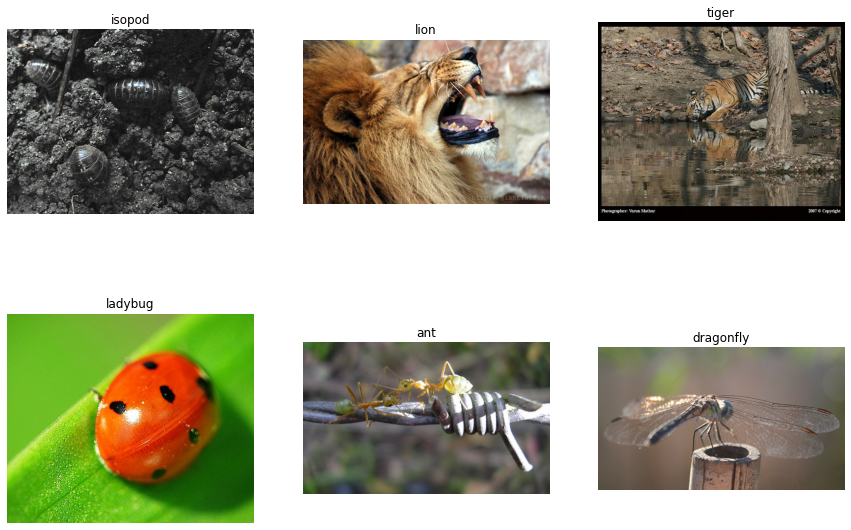

In [8]:
import torchvision.transforms.functional as F
import torch

def img2tensor(img):
  t = F.to_tensor(img)
  t = F.normalize(t, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  return t

def catId2names(nums):
  titles = []
  for num in nums:
    titles.append(imagenet_labels[str(num.item())][1])
    titles.reverse()
  return ", ".join(titles)
  
for i in range(6,12):
  img, label = microImgNet[i*6]
  tensor = img2tensor(img)
  out = alexnet(tensor.unsqueeze(0)) # Add batch dimension
  labels_num = torch.argsort(out[0]) # Ascending order
  weights = out[0][-5:]
  predicted = catId2names(labels_num[-5:]) # Top 5
  titles = []
  name =  microImgNet.labels[i*6][1] 
  show(img,name,i-6,predicted)

##### $\color{brown}{\text{Дополнительная информация}}$ 
## Архитектура ZFnet(2013 г.)

[Visualizing and Understanding Convolutional Networks (Zeiler et al., 2013)](https://arxiv.org/abs/1311.2901)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_5.png"  width="1000"><center>
<center><em>Архитектура сети ZFNet (модифицированно из Zeiler et al., 2013).</em><center>




<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_5_.png"  width="1000"></center>
<center><em>Архитектура сети ZFNet (модифицированно из Zeiler et al., 2013).</em></center>

*Тюнингованный AlexNet*

В 2013 году выиграла соревнования созданная учеными из Йорского университета нейросеть ZFnet, достигнув результата 11.7% — в ней AlexNet использовалась в качестве основы, но с изменёнными параметрами и слоями.

Отличия от AlexNet небольшие:
* Немного поменялись размеры фильтров (было 11, стало 7);
* Увеличилось общее количество фильтров;

В целом и количество слоев, и общая структура сети, когда слои свёртки и пулинга перемежаются друг с другом, а затем идут два полносвязных слоя, сохранились.


# Обзор сети VGGNet(2014 г.)
[Very Deep Convolutional Networks for Large-Scale Image Recognition (Simonyan et al., 2014)](https://arxiv.org/abs/1409.1556)

Karen Simonyan and Andrew Zisserman (Visual Geometry Group — **Oxford**)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_6.png"  width="400" rotate="180"></center>
<center><em>Сравнение архитектур сетей AlexNet, VGG16 (использует 16 слоев) и VGG19 (использует 19 слоев). Модифицированно из Simonyan et al., 2014.</em></center>

[Краткое описание VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

* Появление "стандартных" блоков внутри модели;
* Свёртки 3x3.





В 2014-ом году в Оксфорде была разработана модель VGGNet. Сеть получилась более точной и более глубокой.

Авторы VGG подумали: А что, если нам взять AlexNet и увеличить его в глубину путем повторения блоков (*stacking*)? В то время идея *стакинга* была еще не очевидна. Для этого они выделили базовый блок `3x3 Conv -> 3x3 Conv -> Pool` и повторили его $N$ раз (есть разные варианты, такие как VGG11 — 11 повторений блока, VGG16 — 16 повторений и так далее).

На изображении выше изображены сети AlexNet и две версии VGG-16 и VGG-19 с 16 и 19 слоями соответственно. На соревнованиях победила более глубокая VGG19, достигнув более чем в два раза лучшего результата по сравнению с AlexNet.

Несколько фактов об архитектуре VGGNet:

* Нейросеть заняла 2 место в задаче классификации и 1 место в локализации на соревновании ImageNet (при локализации необходимо не только классифицировать объект, но и обвести его в ограничивающие рамки);

* Процедура обучения такая же, как у AlexNet;

* Слои нормализации отсутствуют.

В прикладных задачах обычно используются (причём до сих пор) архитектуры VGG16 или VGG19 (VGG19 работает лучше, но расходует больше памяти). 

Особенности архитектуры VGG: все свёрточные слои имеют фильтры с рецептивным полем размера 3×3, они объединены в блоки, состоящие из некоторого количества свёрток с разным (постепенно увеличивающимся) количеством фильтров. Затем идут слои пулинга. Появление "стандартных" блоков внутри модели — одно из важных нововведений. Идея базового блока внутри сети будет достаточно широко использоваться дальше.

Разберем на коде:

In [9]:
from torchvision import models
vgg = models.vgg16(pretrained=False) # Change on True if you want to use VGG to predict something
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Оценка памяти занимаемой моделью



Чтобы понять, в чем смысл этих усовершенствований, нужно оценить количество памяти для хранения весов и количество операций, которые требуется выполнить при прямом прохождении сигнала через сеть.

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_7.png"  width="650"></center>
<center><em>Пример свертки с фильтрами малого размера.</em></center>

Чем больше особенностей попадает в рецептивное поле свёртки ("полем зрения"), тем к лучшей генерализации она должна быть способна. Несмотря на это, авторы сети решили отказаться от использования свёрток с большим рецептивным полем в пользу скорости потому, что оказалось, что размер можно заменить количеством (2 маленьких фильтра работают как один большой или даже лучше).

Основная причина, по которой они начали об этом думать — это увеличение сложности. **Большее количество слоев требует больше памяти, весов и вычислительных мощностей**.

На слайде изображен один слой. Тензор $\color{orange}{\text{оранжевого}}$ цвета — это вход, его мы не считаем.

Первый параметр — **количество элементов на выходе слоя**. $\color{blue}{\text{Синий}}$ тензор — это веса, для которых требуется память во время работы модели. Чтобы понять, сколько нужно памяти, чтобы хранить веса, которые мы получаем, нужно умножить количество фильтров на пространственные размеры изображения и на количество байт, которые требуются для хранения одного элемента.

**Количество весов (параметров)** — это пространственные размеры одного фильтра, умноженные на количество слоев и на количество фильтров. В то время, как правая часть занимает память только во время работы, обученные веса являются ценностью и должны сохраняться на диск.

**Количество операций, которые нам потребуются** — это количество элементов на выходе, которые мы хотим получить, умноженное на количество операций. Для получения каждого элемента нужно свернуть фильтр, который имеет размер К×К с каждым слоем входа.

Всё это будет учитываться при построении сетей большего размера.


Оценка памяти для хранения параметров слоя:

In [10]:
from torch import nn
import numpy as np

conv_layer = nn.Conv2d(3,64,5,stride = 1, padding = 1)
for tag, p in conv_layer.named_parameters():
    print('Memory reqired for %s: %.2f kb' % (tag, (np.prod(p.shape) * 4)/1024))

Memory reqired for weight: 18.75 kb
Memory reqired for bias: 0.25 kb


(224 \* 224 \* 3)*(96 * 11 * 11) = 14450688 * 11 * 11 =  14450688 * 121  =1748533248 - количество операций

(224 * 224 * 3) * (96 * 7 * 7) = 14450688 * 7 * 7      121/49  = ~2.5 раза меньше чем 11*11 

(224 * 224 * 3) * (96 * 5 * 5) = 14450688 * 5 * 5      49/25 = ~2 раза меньше чем 7*7

(224 * 224 * 3) * (96 * 3 * 3) = 14450688 * 3 * 3      25/9 = ~2.7 раза меньше чем 5*5


### Размер рецептивного поля

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_8.png"  width="850"></center>
<center><em>Две свёртки 3×3 вместо одной 5×5.</em></center>

Авторы стремились уменьшить количество параметров, используя следующую идею:

Допустим, мы свернули часть изображения с фильтром 5×5 (на слайде выше — $\color{green}{\text{квадрат зеленого цвета}}$), получили одну активацию (одна свёртка — одна активация). Если же начать сворачивать ту же область с фильтром 3×3, то мы получим блок активаций ($\color{red}{\text{изображен красным}}$). Но если второй раз применить такой же фильтр (размером 3×3) уже к блоку А2, он его закроет полностью и мы получим единичную активацию.

Для того же рецептивного поля свёртка с двумя последовательными фильтрами 3×3 будет эквивалентна свёртке с одним фильтром 5×5. При этом потребуется меньшее количество параметров, потому что в данном случае мы складываем две свёртки. В случае же с одним фильтром 5×5 это зависит от размера фильтра, который возводится в квадрат. Соответственно, $2⋅(3^2⋅𝐶^2)$ меньше, чем $5^2⋅𝐶^2$.



<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_9.png"  width="850"></center>
<center><em>Три свёртки 3×3 вместо одной 7×7.</em></center>

Если же размер фильтра будет ещё больше, то будет больше и выгода.

Получается, что можно заменять фильтры, не теряя при этом их обобщающую способность. К тому же в процессе применения этих нескольких фильтров мы добавляем дополнительные нелинейности, которые нам обеспечивают находящиеся между свёртками функции активации. То есть операция получается достаточно выигрышной.


##### $\color{brown}{\text{Дополнительная информация}}$ 

Если очень хочется построить картинки с квадратиками самостоятельно

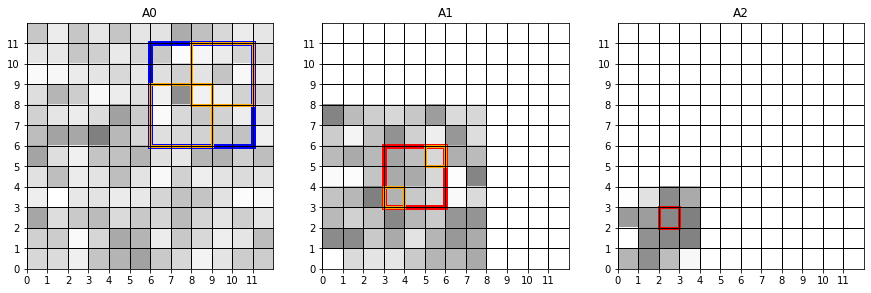

In [11]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

input_tensor = torch.randn((1,1,12,12))
conv_5x5 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,5))

with torch.no_grad():
    out_conv_5x5_1 = conv_5x5(input_tensor)
    out_conv_5x5_2 = conv_5x5(out_conv_5x5_1)

max_0 = input_tensor.size(-1)
max_1 = out_conv_5x5_1.size(-1)
max_2 = out_conv_5x5_2.size(-1)

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(input_tensor.squeeze().numpy(), cmap='Greys', extent = (0,max_0,0,max_0), alpha=0.5)
ax[0].set_xticks(np.arange(0,max_0,1))
ax[0].set_yticks(np.arange(0,max_0,1))

ax[1].imshow(out_conv_5x5_1.squeeze().numpy(), cmap='Greys', extent = (0,max_1,0,max_1), alpha=0.5)
ax[1].set_xticks(np.arange(0,max_0,1))
ax[1].set_yticks(np.arange(0,max_0,1))

ax[2].imshow(out_conv_5x5_2.squeeze().numpy(), cmap='Greys', extent = (0,max_2,0,max_2), alpha=0.5)
ax[2].set_xticks(np.arange(0,max_0,1))
ax[2].set_yticks(np.arange(0,max_0,1))

ax[0].add_patch(
     patches.Rectangle(
        xy=(6, 6),
        width=5,
        height=5,
        fill=False,
        edgecolor='blue',
        linewidth=5
     )) 

ax[0].add_patch(
     patches.Rectangle(
        xy=(6, 6),
        width=3,
        height=3,
        fill=False,
        edgecolor='orange',
        linewidth=3,
     )) 

ax[0].add_patch(
     patches.Rectangle(
        xy=(8, 8),
        width=3,
        height=3,
        fill=False,
        edgecolor='orange',
        linewidth=3,
     )) 

ax[1].add_patch(
     patches.Rectangle(
        xy=(3, 3),
        width=3,
        height=3,
        fill=False,
        edgecolor='red',
        linewidth=5
     )) 

ax[1].add_patch(
     patches.Rectangle(
        xy=(3, 3),
        width=1,
        height=1,
        fill=False,
        edgecolor='orange',
        linewidth=3
     )) 

ax[1].add_patch(
     patches.Rectangle(
        xy=(5, 5),
        width=1,
        height=1,
        fill=False,
        edgecolor='orange',
        linewidth=3
     )) 

ax[2].add_patch(
     patches.Rectangle(
        xy=(2, 2),
        width=1,
        height=1,
        fill=False,
        edgecolor='red',
        linewidth=3
     )) 

ax[0].set_title('A0')
ax[1].set_title('A1')
ax[2].set_title('A2')

for a in ax:
    a.set_xlim(0,max_0)
    a.set_ylim(0,max_0)
    a.grid(color='black', linewidth=1, which='major')

### Сколько памяти и параметров VGG16

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_10.png"  width="800"></center>
<center><em>Архитектура VGG16 с параметрами слоев (модифицированно из Simonyan et al., 2014).</em></center>

Отчасти благодаря такой экономии получилось сделать большую по тем временам сеть (16 слоев), но, несмотря на способы уменьшить вычислительную сложность и количество параметров, сеть все равно получилась огромной (для 16-тислойной сети одно изображение в памяти занимало 96 МБ).




<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_11.png"  width="900"></center>
<center><em>Сравнение параметров AlexNet и VGG16.</em></center>

* Основная часть памяти расходуется на большие свёртки в начальных слоях, где пространственные размеры (ширина и высота) велики;

* Больше всего весов в полносвязанных слоях;

* Вычислительные ресурсы нужны в первую очередь для сверток.


VGG-16 получилась существенно больше по сравнению с и так довольно объемной AlexNet, и тем более по сравнению с современными моделями.

В значительной степени с этим связано дальнейшее направление развития моделей. В следующем году ImageNet выиграла сеть под названием GoogleNet.


##### $\color{brown}{\text{Дополнительная информация}}$ 
Оценка ресурсов GPU

Что бы убедиться самостоятельно в размерах сетей установим библиотеку для мониторинга ресурсов GPU: 

In [12]:
!pip install GPUtil

You should consider upgrading via the '/Users/balepka/PycharmProjects/msuAI/venv/bin/python -m pip install --upgrade pip' command.


In [13]:
import humanize
import GPUtil as GPU
import psutil
import os
import torch

def gpu_usage():
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    if len(GPUs) == 0:
        return False
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))



Посмотрим, сколько памяти потребуется VGG19 и какого размера batch можно использовать.

In [ ]:
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg19 = torchvision.models.vgg19(pretrained = False, progress = True)
vgg19.requires_grad=True
vgg19.to(device)

!nvidia-smi # Common GPU info

vgg19.train()

for batch_size in [1,8,16,32,64]:
  input = torch.rand(batch_size,3,224,224,device = device)
  out = vgg19(input)
  print("Batch size", batch_size)
  gpu_usage()


zsh:1: command not found: nvidia-smi
Batch size 1
Batch size 8
Batch size 16
Batch size 32


Очистка памяти:

In [ ]:
!nvidia-smi 

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
input = None #del input 
out = None #del out

!nvidia-smi 

# Обзор сети GoogleNet(2014 г.)

[Going Deeper with Convolutions (Szegedy et al., 2014)](https://arxiv.org/abs/1409.4842)

В отличие от предшествующих моделей разработана в коммерческой компании с целью реального применения. 

Поэтому основной упор был сделан на эффективности.


<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_12.png"  width="400"></center>
<center><em>Inception module (модифицированно из Szegedy et al., 2014)</em></center>

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_12_.png"  width="900"></center>
<center><em>Архитектура GoogleNet (модифицированно из Szegedy et al., 2014)</em></center>

GoogleNet (так же часто встречается название Inception) — ещё более глубокая архитектура с 22 слоями. Она содержит всего 5 миллионов параметров — в 12 раз меньше, чем у AlexNet. При этом сеть оказалась немного более точной (ошибка снизилась с 7.3% до 6.7%).

Рассмотрим, за счёт чего удалось достичь такого огромного выигрыша в ресурсах, так как многие идеи, которые впервые были использованы для GoogleNet, активно применяются до сих пор.


 ## Inception module

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_13.png"  width="750"></center>
<center><em>Наивная реализация Inception module (модифицированно из Szegedy et al., 2014)</em></center>


* Очень дорогие вычисления;
* Слой пулинга также сохраняет глубину признака, что означает, что общая глубина после конкатенации на каждом слое может только расти.



Для того, чтобы разработать с наибольшей вычислительной эффективностью, был придуман так называемый модуль Inception, основная идея которого заключается в том, что он сам по себе является небольшой локальной сетью. Его архитектура состоит из множества таких модулей, следующих друг за другом.

Вместо того, чтобы добавлять новые слои фильтров один над другим, инженеры из Google решили делать свёртки параллельно. Они поместили разные варианты сверток в один блок и объединили их результаты между собой (конкатенация, а не сложенине).

То есть фильтры применяются параллельно. Затем результаты объединяются, и создаётся выходной сигнал, который переходит на следующий слой.


Посмотрим на архитектуру сети в Tensorboard

In [ ]:
import os
# launching Tensorboard in Colab
def reinit_tensorboard(clear_log = True):
  # Log files are read from this directory:
  logs_base_dir = "runs"
  if clear_log:
    #  clear logs
    !rm -rfv {logs_base_dir}/*
    os.makedirs(logs_base_dir, exist_ok=True)
  # Colab magic
  %load_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

In [ ]:
import torchvision
import torch
#https://pytorch.org/vision/stable/_modules/torchvision/models/googlenet.html#googlenet
#https://hackmd.io/@bouteille/Bk-61Fo8U
googlenet = torchvision.models.googlenet()

from torch.utils.tensorboard import SummaryWriter

reinit_tensorboard(clear_log = True)
writer = SummaryWriter(comment = "googlenet")
input = torch.rand((1,3,224,224))
writer.add_graph(googlenet,input)
writer.close()



**Case Study: GoogleNet**

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_14.png"  width="850"></center>
<center><em>Наивные реализации Inception module и Inception module с уменьшением размерности (модифицированно из Szegedy et al., 2014).</em></center>

При таком подходе "в лоб" (когда фильтры применяются параллельно) количество фильтров всё равно растет довольно быстро.

Чтобы этого избежать, введены так называемые «узкие места» — слои с фильтром 1×1, уменьшающие глубину изображения. Благодаря им удалось достичь того, чтобы количество каналов на входе и на выходе либо не менялось, либо менялось только в моменты, когда это необходимо.

Как видно на изображении выше, для свёрток с неединичным фильтром перед ними добавляется свёртка размером 1×1, при этом max pooling ненастоящий, его шаг 1, он не меняет пространственные размеры, а просто выбирает свёртку с максимальным значением из поля 3×3.
Такой слой работает более эффективно.


## 1x1 Convolution





<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_15.png"  width="550"></center>
<center><em>Уменьшение глубины изображения с помощью 32 фильтров 1×1.</em></center>

Свёртку 1х1 можно сравнить с полносвязанными слоями, когда мы берём столбик из этого тензора и сворачиваем его с некоторым количеством фильтров, получаем на выходе вектор (то есть получаем из одного вектора другой).


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_16.png"  width="700">
<center><em>Наивная реализация Inception module с уменьшением размерности (модифицированно из Szegedy et al., 2014).</em></center>

Количество параметров уменьшается в два с лишним раза по сравнению с лобовой реализацией. Сеть получается значительно экономичнее.

Использование таких модулей и отсутствие полносвязных слоёв делают GoogleNet очень эффективной и достаточно точной сетью. Но это далеко не все нововведения, которые появились в этой модели.


## "Stem network"

В составе GoogleNet есть небольшая подсеть — Stem Network. Она состоит из трёх свёрточных слоёв с двумя pooling-слоями и располагается в самом начале архитектуры.

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_17.png"  width="1200"></center>
<center><em>Архитектура GoogleNet (модифицированно из Szegedy et al., 2014). В первых слоях быстро уменьшаются пространственные размеры. </em></center>
 
На входе располагаются свёртки с большим фильтром. Они служат для того, чтобы достаточно быстро и сильно уменьшить пространственные размеры (по сути сжать изображение перед параллельной обработкой), чтобы минимизировать количество элементов в слоях.

Отдельно стоит обратить внимание на завершающую часть сети: Global Average Pooling. Несложно заметить, что больше всего параметров появляется в полносвязных слоях, где каждый элемент связан с каждым. Сверточный слой очень экономичный по сравнению с полносвязным. В предыдущих моделях в конце было два полносвязных слоя, в которых находилась большая часть весов.


## Global Average Pooling

[Network In Network, Lin et al., 2013](https://arxiv.org/abs/1312.4400)

Полносвязанные слои заменены на GAP.

* Меньше весов;
* Независимость от размера входа;
* Регуляризация;
* Уменьшение числа параметров;
* Положительно влияет на переобучение.

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_18.png"  width="570"></center>
<center><em>Global Average Pooling (модифицированно из Lin et al., 2013)</em></center>



[Блог-пост про Global Average Pooling](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/)

Идея в том, что все пространственные размеры, какими бы они не были (например, 6х6), сворачиваются в единицу.
Мы накладываем фильтр размером 6х6 и берем среднее значение. То есть делаем пулинг с фильтром такого размера. Это происходит независимо по каждому слою.

Раньше считалось, что свертывание пространственных измерений трехмерного (пространственно-канального) тензора в сверточной нейронной сети (CNN) в вектор посредством глобального объединения удаляет всю пространственную информацию. Но современные исследования это оспаривают. 

В частности, в статье [Global Pooling, More than Meets the Eye: Position Information is Encoded Channel-Wise in CNNs (Islam et al., 2021)](https://arxiv.org/abs/2108.07884) авторы демонстрируют, что позиционная информация кодируется на основе упорядочивания размеров каналов, в то время как семантическая информация в основном не кодируется. 

При этом нам не нужно запоминать кучу параметров, как в полносвязном слое, и таким образом выполняется некоторая регуляризация, которая позволяет, в том числе, бороться с переобучением, ввиду того, что мы избавляемся от части менее важных активаций.


In [ ]:
# Full list of labels
from IPython.display import clear_output 
!wget 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
!git clone https://github.com/ajschumacher/imagen.git
clear_output()

In [ ]:
import torch.nn as nn
import torch
from PIL import Image
import torchvision 

def file2tensor(filename):
  img = Image.open(filename)
  t = torchvision.transforms.functional.to_tensor(img)
  t = torchvision.transforms.functional.normalize(t, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  return t

class CNNfromHW(nn.Module):

    def __init__(self,conv_module = None):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(3,16,5,padding=2) # 16xHxW
        self.pool = nn.MaxPool2d(2,2) # 16 x H/2 x W/2 
        self.conv2 = nn.Conv2d(16,32,3,padding=1) # 32 x H/2 x W/2
        self.gap = nn.AdaptiveAvgPool2d((1,1)) # Any spatial size -> 32x1x1
        self.fc = nn.Linear(32,10)        

    def forward(self, x):
        print("Input shape",x.shape)
        x = self.conv1(x) # 16xHxW
        x = self.pool(x) # 16 x H/2 x W/2 
        x = self.conv2(x) # 32 x H/2 x W/2
        x = self.activation(x) # Any spatial size -> 32x1x1
        x = self.gap(x)
        scores = self.fc(x.flatten(1))
        print("Output shape",scores.shape)
        return scores

print("CIFAR10 like")
input = torch.rand(1,3,32,32)
model_with_gap = CNNfromHW()
out = model_with_gap(input)


print("Arbitrary size")
# Different sizes work too!
aramdillo_t = file2tensor('imagen/imagen/n02454379_10511_armadillo.jpg')
out = model_with_gap(aramdillo_t.unsqueeze(0))



## Затухание градиента

**GoogleNet: дополнительный классификатор**

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_19.png"  width="700"></center>
<center><em>Архитектура GoogleNet (модифицированно из Szegedy et al., 2014). Отдельно вынесен блок - дополнительный классификатор.</em></center>

Помимо основного классификатора на выходе сети добавлены два дополнительных классификатора, встроенных в промежуточные слои. Они понадобились для того, чтобы улучшить обратное распространение градиента, потому что без батч-нормализации в таких глубоких сетях градиент очень быстро затухал, и обучить сеть такого размера было серьёзной проблемой.

Обучение VGG осуществлялось непростым способом: сначала обучали 7 слоев, затем добавляли туда следующие и обучали это вручную. Без использования батч-нормализации вряд ли получится повторить результат.

Google подошел более системно, он добавил дополнительные выходы, которые способствовали тому, чтобы градиент меньше затухал. Благодаря этому удалось решить серьёзную на тот момент проблему, которая ограничивала возможность обучения глубоких моделей.
Статья про батч-нормализацию появилась как раз в 15ом году, видимо уже после выхода этой модели.


# Появление "глубоких" моделей (deep models)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_20.png"  width="750"></center>
<center><em>Победители ImageNet Large Scale Visual Recognition Challenge (ILSVRC).</em></center>

В 15ом году появились существенно более глубокие модели. 

# Обзор сети ResNet(2015 г.)

**2015 увеличение количества слоев**

[Deep Residual Learning for Image Recognition (He et al., 2015)](https://arxiv.org/abs/1512.03385)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_21.png"  width="550"></center>
<center><em>График обучения и теста двух модификаций ResNet с 20 и 56 слоями соответственно (модифицированно из He et al., 2015).</em></center>

Но одной батч-нормализации было недостаточно, потому что появилась возможность благодаря ее использованию тренировать сети с большим количеством слоев (на слайде выше — пример 56-слойной сети Microsoft). Но, как видно из графиков, у неё ошибка и на тренировочном, и на тестовом датасете больше, чем у 20-тислойной сети.


В 2015 году соревнования выиграла сеть ResNet, произведя настоящую революцию глубины нейросетей. Она состояла из 152 слоёв и снизила процент ошибок до 3,57%. Это сделало её почти в два раза эффективнее GoogleNet.

Возникло предположение, что сеть, состоящая из большего количества слоёв должна работать как минимум не хуже, чем сеть меньшего размера, потому что в ней есть те же 20 слоев.

Что же происходит с нейросетью, когда мы увеличиваем число слоёв? Можно ли, взяв обычную архитектуру вроде VGG, просто накидывать (*stacking*) всё больше и больше слоёв друг на друга и достигать лучшей точности? Нет, нельзя. Скорее всего, более глубокая нейросеть покажет даже худшие результаты как при обучении, так и при тестировании. И переобучение здесь не при чём, поскольку тогда ошибка на train была бы низкой.

Можно провести подобную аналогию: если мы видим изображение какое-то короткое время и нам нужно быстро его описать, мы скорее всего заметим какие-то крупные объекты (сцена: либо это помещение, либо лес, улица, возможно, мы отметим фигуры людей на переднем плане или же автомобили, здания). Если же требуется более подробно описать рассмотреть и описать картинку, мы уже к этому же имеющемуся описанию, добавим детали: во что одеты люди, какого цвета машины, погода и так далее.

Возможно, руководствуясь подобными соображениями, был придуман остаточный слой (residual).


## Resudial connection

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_22.png"  width="700"></center>
<center><em>Сравнение Residual Block с "обычными" слоями (модифицированно из He et al., 2015).</em></center>

* сумма, а не конкатенация;
* Batch normalization присутствует.


Идея Residual Block состоит в том, что мы к имеющемуся уже набору признаков добавляем значения некоторых новых: то есть не перезаписываем то, что было на предыдущем слое, а копируем признаки, сохраняем их и через несколько слоев суммируем (а не конкатенируем) их с результатами свёрток на нескольких слоях, которые здесь присутствуют.

Всё это вместе называется остаточным слоем или residual block.

Применение этого метода дало потрясающий эффект: с одной стороны, по этому каналу стал хорошо распространяться градиент без дополнительных хаков, с другой стороны, перестали теряться важные свойства, которые удалось выделить на предыдущих блоках.

Если сеть из 20ти слоев способна распознавать ImageNet с точностью более 90%, значит что в этих слоях уже содержится большая часть информации, а детали не должны её затирать. Такая архитектура показала очень хороший результат.


## Архитектура ResNet

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_23.png"  width="730"></center>
<center><em>Архитектура ResNet (модифицированно из He et al., 2015). Используется стаккинг residual blocks, каждый residual block состоит из двух 3x3 conv слоев, переодически количество фильтров в свертках удваиваеется, а размер выходных слоев уменьшается в 2 раза (за счет stride = 2). Добавился дополнительный conv слой в начале сети. Отсутствуют FC слои (кроме последнего который предсказывает класс).</em></center>

Из таких блоков удалось построить очень глубокую сеть (были эксперименты из 1000 слоев). Для решения конкретной задачи победы на ImageNet хватило 150 слоев (добавление большего количества блоков уже не давало прироста точности).

В ResNet используются многие идеи, которые присутствовали в предыдущих моделях: вначале изображение резко уменьшается, дальше используются блоки 3х3, как в VGG, далее применяется глобальный пулинг вместо полносвязных слоев. Блоки состоят из конструкций, изображенных выше: две свёртки 3Х3 и прибавление результата предыдущего слоя.

Также на каждом слое перед активацией используется батч-нормализация.


##### $\color{brown}{\text{Дополнительная информация}}$ 
ResNet for ImageNet


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_24.png"  width="830">

Если посмотреть на реализацию ImageNet, то вот что происходит с размерами изображения: сначала его уменьшают обычной свёрткой с большим фильтром, а потом, в зависимости от глубины сети, идёт некоторое количество блоков без уменьшения, затем происходит даунсэмплинг. При этом здесь используется не pulling, а просто свёртка с шагом 2.

Таким образом, через некоторый набор этих блоков, вес изображений уменьшается в два раза. На выходе average pooling. Даже такая огромная 152-хслойная сеть с точки зрения потребления ресурсов получилось более эффективной, чем VGG-19.


## ResNet: bottleneck layer

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_25.png"  width="450"></center>
<center><em>В более глубоких сетях (ResNet-50+) для повышения эффективности используется слой "bottleneck" (похожим образом, что и в GoogLeNet). Модифицированно из He et al., 2015.</em></center>

Вес изображений уменьшается в два раза. На выходе average pooling. Даже такая огромная 152-х слойная сеть с точки зрения потребления ресурсов получилось более эффективной, чем VGG-19.

Это ещё было достигнуто также за счёт того, что в более глубоких сетях вместо двух блоков 3х3 применялся более эффективный блок - *bottleneck*, где сначала происходит свёртка 1х1 и мы уменьшаем количество фильтров. С этим маленьким количеством фильтров делаем свёртку 3х3, а потом восстанавливаем количество фильтров до начальных значений, чтобы можно было прибавить к ним вход, иначе у нас не совпадут размерности.

## ResNet реализация в Pytorch

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_26.png"  width="800"></center>
<center><em>Код для базового блока и для bottleneck для сетей со количеством слоев до 50. </em></center>

Так выглядит в коде этот базовый блок для сетей со слоями до 50 слоёв. То есть  свёртка, батч-нормализация, активация, свёртка, батч-нормализация. Если некоторый параметр (downsample) задан, то вызывается несколько слоев для downsampling: то есть это свёртка и ReLU с батч-нормализацией. Реализовано путем простого прибавления значения выходов к входам. 


[Модель ResNet на Torchvision](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html)


In [ ]:
from torchvision import models,utils
resnet = models.resnet18(pretrained=False)
print(resnet)

##### $\color{brown}{\text{Дополнительная информация}}$ 
Инициализация весов для ResNet

[2019 Fixup Initialization: Residual Learning Without Normalization (Zhang et. al, 2019)](https://arxiv.org/abs/1901.09321)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_27.png"  width="270"></center>
<center><em>Residual Block (модифицированно из He et al., 2015).</em></center>

Если инициализировать веса с помощью случайного Гауссова распределения, где mean=0, а variance=2/n (MSRA), то мы получим, что $\text{Var}(F(x)) = \text{Var}(x)$, при этом $\text{Var}(F(x) + x) > \text{Var}(x)$ -> variance увеличивается с каждым новым слоем!

Решение: инициализировать первый conv слой с помощью MSRA, а второй conv слой - нулями. Тогда $\text{Var}(x + F(x)) = \text{Var}(x)$.



[Блог-пост про Fixup Initialization](https://towardsdatascience.com/understanding-fixup-initialization-6bf08d41b427)

В дополнение можно заметить, что не так давно вышла статья, где авторы обратили внимание, что правила, которые мы рассматривали для инициализации (что дисперсия входов должна равняться дисперсии выходов) нарушается при таком подходе, потому что мы здесь к выходам добавляем некоторые значения. Авторы  предлагают решить эту проблему довольно странным на первый взгляд способом — обнулить веса 2-ого слоя в блоке при инициализации. На первый взгляд это звучит как ошибка. Но поскольку значение cо входа будут сложены с выходами блока, то при обратном распространении градиент не будет нулевым.




## Обучение ResNet

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_28.png"  width="550"></center>
<center><em>График обучения и теста двух модификаций ResNet с 20 и 56 слоями соответственно (модифицированно из He et al., 2015).</em></center>

Когда точность выходила на плато, шаг обучения понижали вручную. Это давало хороший эффект: ошибка падала.

Помимо того, что ResNet c огромным отрывом выиграла ImageNet у моделей прошлого года и, как уже видно по некоторым исследованиям, её результаты лучше, чем у человека, решения на базе этой архитектуры также стали победителями на соревнованиях по детектированию и сегментации.


# Обзор сети ResNeXt(2016 г.)

[2016 Aggregated Residual Transformations for Deep Neural Networks (Xie et al., 2016)](https://arxiv.org/abs/1611.05431)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_34.png"  width="550"></center>
<center><em>Сравнение блоков ResNet и ResNeXt (Адаптировано из Xie et al., 2016). ResNeXt создан тем же коллективом авторов, что и ResNet. Увеличение ширины residual block достигается путем использования параллельных веток "cardinality"), которые по духу, схожи с Inception module. </em></center>

Еще одна идея — это ResNeXt. Эта сеть выиграла ImageNet в следующем году. Здесь налицо заимствование идеи от Inception модуля. Можно обрабатывать не сразу все каналы, а распараллелить обработку и обрабатывать по несколько каналов. 

Эта идея уже была в AlexNet, но она там присутствовала вынужденно, потому что AlexNet обучали на двух видеокартах параллельно, просто в силу того, что модель не помещалась в память одной видеокарты на тот момент (видеокарты были по 3 Гб) и уже в конце на полносвязных слоях объединяли результаты двух карт, то есть там обработка происходила параллельно вынужденным образом. 


In [ ]:
from torchvision import models,utils
resnext = models.resnext50_32x4d(pretrained=False)
print(resnext)

## Groupped Convolution

[Блог-пост про различные типы сверток](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_35.png"  width="600"></center>
<center><em>Групповые свертки позволяют обрабатывать входных данные параллельно. В качестве бонуса - уменьшение числа параметров, и дополинтельная регуляризация.</em></center>

На изображении выше на AlexNet видно, что сеть у них разделена на 2 части. 

Это демонстрация того, как это работает в обычном слое: можно каким-то образом разделить тензор так, что часть каналов начнет обрабатываться одной свёрткой, а часть другой, а потом их просто конкатенировать. Глубина фильтров, которые потребуются для этой свёртки, будет меньше. 



## Grouped convolution in Pytorch


Не нужно дожидаться результатов предыдущих операций, можем считать их параллельно. Этот механизм уже заложен в свёртку, которой пользовались в pytorch. Параметр group = 1, по умолчанию. Это означает, что групп нет.

Сравним время которое требуется на обычную свертку с `groups = 1` и `groups = 64`

In [ ]:
# CPU test
from torch import nn
import time 
import torch

def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()

input = torch.rand(8,512,112,112)
start = time_synchronized() 
normal_conv = nn.Conv2d(512,1024,3,groups = 1)
out = normal_conv(input)
tm = time_synchronized() -start
print(f"Normal convolution take  {tm} sec.")

start = time_synchronized() 
groupped_conv = nn.Conv2d(512,1024,3,groups = 64)
out = groupped_conv(input)
tm = time_synchronized() -start
print(f"Groupped convolution take  {tm} sec.")




In [ ]:
# GPU test
start = time_synchronized() 
normal_conv = nn.Conv2d(512,1024,3,groups = 1).to(device)
out = normal_conv(input.to(device))
tm = time_synchronized() -start
print(f"Normal convolution take  {tm} sec.")

start = time_synchronized() 
groupped_conv = nn.Conv2d(512,1024,3,groups = 64).to(device)
out = groupped_conv(input.to(device))
tm = time_synchronized() -start
print(f"Groupped convolution take  {tm} sec.")

Очистим память:



In [ ]:
input = None
out = None

## ResNext, Inception, grouped conv


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_37.png"  width="850">

[Блог-пост про ResNeXt](https://towardsdatascience.com/review-resnext-1st-runner-up-of-ilsvrc-2016-image-classification-15d7f17b42ac)

ResNeXt повторяет строительный блок, который объединяет набор преобразований с одинаковой топологией. По сравнению с ResNet, он раскрывает новое измерение, кардинальность (размер набора преобразований), как существенный фактор в дополнение к измерениям глубины и ширины.

То есть эта операция сгруппированных сверток оказалась достаточно эффективной. 


## Feature extraction

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_30.png"  width="650">

Дело в том, что в процессе выполнения задачи классификации картинок у нас появляются веса, которые отвечают за распознавание разных особенностей, разных паттернов на изображениях. Эти веса в свёрточных слоях представляют большую ценность, потому что мы можем их использовать в данном случае для классификации.




<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_30_.png"  width="650">

Но для решения другой задачи мы можем часть сети просто отрезать и заменить её чем-то еще:

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_31.png"  width="650">


Например, мы можем на основании карт активаций, которые мы получили (которые уже намного меньше, чем были начальные изображения) проводить детектирование в этих картах, проводить сегментацию, можем генерировать вектора признаков (embedding) для разных задач: для сравнения изображений, для распознавания лиц, трекинга и многого другого.

Часть сети (слева) является достаточно универсальной и получить эти веса можно, обучая сеть распознавать изображения для классификации, а потом использовать ещё  каким-то образом, возможно даже ещё не придуманным в настоящий момент. 

Эта часть сети называется backbone (скелет, основа), на которые уже строятся какие-то дополнительные алгоритмы.


# Сравнение моделей

[Benchmark Analysis of Representative
Deep Neural Network Architectures (Bianco et al., 2018)](https://arxiv.org/abs/1810.00736)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_32.png"  width="800"></center>
<center><em>Сравнение моделей по параметрам Точность vs Количество операций (Bianco et al., 2018)</em></center>

Картинка из статьи 18 года, то есть не последняя, но тем не менее, на них довольно наглядно собрано много информации: здесь есть информация и о размере модели, и о скорости, и о точности. Здесь можно увидеть, что VGG — огромные по объёму модели, но по нынешним меркам они обладают средней точностью. Они требуют больших вычислительных ресурсов, поэтому сейчас их имеет смысл использовать разве что в учебных целях, а модели на базе ResNet (ResNet-50, ResNet-152) довольно хороши: в плане точности какого-то большого отрыва от них здесь не видно. Но, тем не менее, есть модели, которые работают несколько лучше. Рассмотрим их кратко, чтобы было понимание того, куда двигалась мысль в этой области.


# Обзор сети DenseNet(2016 г.)

[Densely Connected Convolutional Networks (Huang et al., 2016)](https://arxiv.org/abs/1608.06993)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_33.png"  width="350"></center>
<center><em>Архитектура DenseNet (адаптировано из Huang et al., 2016). Используется несколько "обходов" и конкатенация вместо суммы. </em></center>

Один из вариантов, что можно сделать — это добавить еще дополнительных связей в обход блоков, чтобы градиент проходил ещё лучше.

Можно заменить сумму на конкатенацию. Это тоже работает, но надо понимать, что конкатенация увеличивает количество признаков. Видимо, с этим можно бороться засчет свёрток 1Х1. Это так называемый DenseNet. С точки зрения ресурсов он, как правило, чуть более требовательный, чем базовый ResNet и немного более точный. 



In [ ]:
from torchvision import models,utils
densenet = models.densenet121(pretrained=False)
print(densenet)

##### $\color{brown}{\text{Дополнительная информация}}$

2016 WideResNet

[Wide Residual Networks (Zagoruyko et al., 2016)](https://arxiv.org/abs/1605.07146)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_38.png"  width="350"></center>
<center><em>Сравнение базового ResBlock и Широкого ResBlock, где используются $F \times k$ фильтры вместо $F$ фильтров в каждом слое (адаптировано из Zagoruyko et al., 2016).</em></center>

Ещё одна идея, связанная уже не с распараллеливанием, а с увеличением количества фильтров: мы можем увеличивать количество фильтров и уменьшить количество слоёв. В такого рода моделях первая цифра — это количество слоёв, вторая — коэффициент, с которым мы увеличиваем количество наших фильтров.

Авторы утверждают что сами по себе residuals значительно более важный фактор, чем глубина. Так же стоит отметить что 50 слойный Wide ResNet показывает лучшие результаты чем оригинальный 152-х слойный ResNet. С точки зрения вычислительных ресурсов использование ширины вместо глубины - более эффективно (parallelizable).

# Архитектура SENet(2017 г.)

[Squeeze-and-Excitation Networks (Hu et al., 2017)](https://arxiv.org/abs/1709.01507)

[Блог-пост про Squeeze-and-Excitation Networks](https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_39.png"  width="700"></center>
<center><em>Архитектура сети SENet (адаптировано из Hu et al., 2017). Добавлен модуль для взвешивания признаков, используется GAP + 2 FC слоя. Победитель ILSVRC`17 с использованием ResNeXt-152 в качестве базовой архитектуры.</em></center>

# Обзор сети MobileNet(2017 г.)

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Howard et al., 2017)](https://arxiv.org/abs/1704.04861)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_40.png"  width="380"></center>
<center><em>Сравнение сложности вычисления стандартной сети и MobileNet (адаптировано из Howard et al., 2017). Обычные свертки заменены depthwise свёрткой и свёрткой 1х1. Более вычислительно эффективна при небольшой потери точности;
Используются в архитектурах mobileNetV2, ShuffleNet итд ...</em></center>

MobileNet — это сверточная нейронная сеть, специально созданная для работы на CPU на мобильных устройствах с помощью комбинации аппаратно-ориентированного поиска архитектуры сети (*Neural Search*) и последующего улучшения за счёт новых достижений в архитектуре, таких как: новые эффективные версии функций активаций, практичные для мобильных устройств и новый эффективный дизайн сети.

Дизайн сети включает в себя использование жесткой активации swish и модулей squeeze-and-excitation в блоках MBConv.

Давайте разберемся что это такое.

## Swish

Посмотрим что из себя представляет активация Swish

In [ ]:
import matplotlib.pyplot as plt
from torch import nn
swish = nn.SiLU()

array = torch.linspace(-3,3,100)
activated = swish(array)

fig = plt.figure(figsize=(5,5))
plt.plot(array, label='Input')
plt.plot(activated, label='After activation')
plt.legend()
plt.title('Swish')
plt.show()

## Depthwise separable convolution

В то время, как стандартная свёртка выполняет поканальные и пространственно-временные вычисления за один шаг, разделимая по глубине свёртка (*Depthwise separable convolution*) разделяет вычисления на два этапа: глубинная свёртка применяет один свёрточный фильтр для каждого входного канала, а точечная свёртка используется для создания линейной комбинации выходных данных глубинной свёртки. 

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_41.png"  width="650">

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_42.png"  width="650">

In [ ]:
from torchvision import models,utils
mobilenet = models.mobilenet_v3_small(pretrained=False)
print(mobilenet)

## Shuffled Grouped Convolution

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_43.png"  width="750">

# Neural Architecture Search

[Neural Architecture Search with Reinforcement Learning (Zoph et al., 2016)](https://arxiv.org/abs/1611.01578)

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_44.png"  width="600"></center>
<center><em>Схема автоматического поиска архитектуры нейронных сетей (адаптировано из Zoph et al., 2016).</em></center>

Проектировать архитектуры нейронных сетей сложно - давайте автоматизируем это!

- Одна сеть (контроллер) выводит архитектуры сетей
- Выбираем дочерние сети из контроллера и обучаем их 
- После обучения партии дочерних сетей, делаеем градиентный шаг на сети контроллера (используя градиент политики).
- Со временем контроллер учится выдавать хорошие архитектуры!
- ОЧЕНЬ ДОРОГО!!! Каждый шаг градиента на контроллере требует обучения партии дочерних моделей!
- Оригинальная статья обучалась на 800 GPU в течение 28 дней!
- Последующие работы были сосредоточены на более эффективном поиске

# Обзор сети EfficientNet(2019 г.)

[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (Tan et al., 2019)](https://arxiv.org/abs/1905.11946)

Фишка EfficientNet в равномерном масштабировании всех измерений (глубины/ширины/разрешения) с помощью составного коэффициента (*compound coefficient*). 

Например, если мы хотим использовать в $2^N$ больше вычислительных ресурсов, то мы можем просто увеличить глубину сети на $\alpha^N$ ширину на $\beta^N$ и размер изображения на $\gamma^N$ где - $\alpha$, $\beta$ и $\gamma$ постоянные коэффициенты, определяемые grid search на исходной немасштабированной модели.



Метод комбинированного масштабирования обоснован следующей интуицией — если мы берём более большое входное изображение, чем обычно (например, 1024x1024 вместо привычных 256x256), то сети потребуется больше слоёв для увеличения рецептивного поля и больше каналов для захвата более тонких деталей на большом изображении.

Базовая сеть EfficientNet основана на инвертированных узких остаточных блоках MobileNet, в дополнение к блокам сжатия и возбуждения (*squeeze-and-excitation blocks*).

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_45.png"  width="900">

Масштаб модели. (a) - базовая сетевая модель; (b) - (d) отдельно увеличивают масштаб в размерах ширины, глубины и разрешения; (e) - преобразование смешанного масштаба, предложенное в статье, которое масштабируется в едином масштабе. и фиксированная шкала. Три разных измерения шкалы.
[ссылка](https://russianblogs.com/article/37801611697/)

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
print(model)

# Обзор Visual Transformers(2020 г.)

[Visual Transformers: Token-based Image Representation and Processing for Computer Vision (Wu et al., 2020)](https://arxiv.org/abs/2006.03677)

[Реализация](https://github.com/lucidrains/vit-pytorch)

[Блог-пост разбор  ViT](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)


Vision Transformer — это модель для классификации изображений, которая использует архитектуру трансформера. Давайте подробно разберем как она работает


## Архитектура ViT


<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_48.png"  width="700"></center>
<center><em>Архитектура Visual Transformer (адаптировано из Dosovitskiy et al., 2020).</em></center>

Трансформеры работают с последовательностями за счёт механизма внимания (*self-attention*). Но с ним есть одна проблемка — а именно сложность вычислений. 

Положим что $X$ — это вектор (размера $(n,d)$, где $n$ — число токенов и $d$ — размерность каждого токена), который подаётся на вход в *self-attention layer*. Сложность вычисления одноголового слоя будет $O(n^2 d + n d^2)$ (для любознательных расчеты [тут](https://stackoverflow.com/questions/65703260/computational-complexity-of-self-attention-in-the-transformer-model)).


Для тех кто забыл, напомним что $O()$ — это *Big O notation*, которая отражает ресурсы, требуемые для вычисления. Так для $O(1)$ — время вычисления будет постоянным, вне зависимости от количества данных, а для $O(N)$ — расти пропорционально количеству данных.


Разберём на примере: Допустим, мы используем трансформер для предложения длиной в 4 слова — "Мама мылом мыла раму" => у нас есть `4 токена`. Закодируем их в *embeddings* с размерностью `256`. Получим вектор $X$ размером (4,256). Сложность вычисления получится $O(4^2*256+4*256^2) = O(266,240)$.

А теперь попробуем провернуть то же самое для картинки размерами 256 на 256. $O(256^2*256+256*256^2) = O(33,554,432)$. Упс... Кажется, нам так никаких ресурсов не хватит — трансформеры с картинками использовать.

В статье [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020)](https://arxiv.org/abs/2010.11929) предлагается разбивать картинки на кусочки (patches) размером 16x16 пикселей.

In [ ]:
URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Capybara_%28Hydrochoerus_hydrochaeris%29.JPG/1200px-Capybara_%28Hydrochoerus_hydrochaeris%29.JPG'
!wget $URL -O image.jpg

In [ ]:
from torchvision import models,utils, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

img = Image.open('image.jpg')

transform = transforms.Compose([transforms.RandomCrop(800),
                                transforms.Resize(256),
                                transforms.ToTensor()])

img = transform(img)
patches = []
sz = 64
for r in range(0,img.shape[1] , sz):
    for c in range(0,img.shape[2] , sz):
        patches.append(img[:,r:r+sz,c:c+sz])

patches = torch.stack(patches).type(torch.float)

img_grid = utils.make_grid(patches,pad_value=10, normalize=True, nrow=4);
plt.imshow(np.transpose(img_grid , (1, 2, 0)));
plt.axis('off');

Посчитаем сложность для картинки размером (256,256), разбитой на кусочки по 16 px. $O(16^2*16+16*16^2) = O(8,192)$. И впрямь! Аж в 409 раз меньше ресурсов требуется.

Супер, теперь мы можем грузить наши патчи-картинки в **Vi**sual **T**ransformer. Эти патчи подвергаются линейной проекции с помощью MLP и к ним присовокупляются *positional embeddings* (как и обычном трансформере для текста). К полученным векторам добавляют еще один **0***, который называют *class embedding* и обучают трансформер. На выходе берут этот специальный токен **0***, прогоняют его через MLP и предсказывают классы, остальные выходы (а для каждего токена в трансформере есть свой выход) отбрасываются за ненадобностью.

## Предсказание с помощью ViT

In [ ]:
!pip install pytorch_pretrained_vit

In [ ]:
from pytorch_pretrained_vit import ViT
model = ViT('B_16_imagenet1k', pretrained=True)
model.eval()

# Load image
# NOTE: Assumes an image `image.jpg` exists in the current directory
img = transforms.Compose([
    transforms.Resize((384, 384)), 
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])(Image.open('image.jpg')).unsqueeze(0)
print(img.shape) # torch.Size([1, 3, 384, 384])

# Classify
with torch.no_grad():
    outputs = model(img)
print(outputs.shape)  # (1, 1000)

Давайте посмотрим, что нам предсказывает ViT. Для этого подгрузим dict с переводом индексов в человеческие названия:

In [ ]:
labels_URL = 'https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
!wget $labels_URL -O imagenet_labels.txt
import ast
file = open("imagenet_labels.txt", "r")
contents = file.read()
dictionary = ast.literal_eval(contents)


И, собственно, переведем индекс в название:

In [ ]:
print('Top 3 predictions:', [dictionary[x.item()] for x in torch.argsort(outputs)[0][-3:]][::-1])

Ну что ж, почти (капибар в классах Imagenet 1k, как вы могли догадаться, просто нет).

##### $\color{brown}{\text{Дополнительная информация}}$ 

In [ ]:
import torch
import torchvision
from torchvision.datasets import CIFAR10

transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2470, 0.2434, 0.2615])
                                            ]) 

train_set = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

train_set_mini, _ = torch.utils.data.random_split(train_set, [20000, 30000])
test_set_mini, _ = torch.utils.data.random_split(test_set, [2000, 8000])

from torch.utils.data import DataLoader
batch_size = 256

train_loader = DataLoader(train_set_mini, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set_mini, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
!pip install vit_pytorch

In [ ]:
import torch.optim as optim

def validate(model,test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total  

In [ ]:
import torch
from torch import nn
from vit_pytorch import ViT
from torch.utils.tensorboard import SummaryWriter

model  = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


def train(model, criterion, optimizer , num_epochs = 50, tag = "cifar10"):
  
  writer = SummaryWriter(comment = tag)

  for epoch in range(num_epochs):
    hist_loss = 0
    correct = 0
    model.to(device)
    for imgs, labels in train_loader: # get bacth         
        optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
        outputs = model(imgs.to(device)) # call forward inside 
        loss = criterion(outputs, labels.to(device)) # calculate loss
        loss.backward() # calculate gradients
        optimizer.step() # performs a single optimization step (parameter update).
        # stat collection
        _, predicted = torch.max(outputs.data, 1)  
        correct += (predicted == labels.to(device)).sum().item()
        hist_loss += loss.item()
   
    accuracy_v  = validate(model.to('cpu'), test_loader)
    print(accuracy_v)
   
    writer.add_scalars("Accuracy", { 
          'Val': accuracy_v,
          'Train' : correct / len(train_loader.dataset)
      }, epoch)

    writer.add_scalars("Loss", { 
          
          'Train': hist_loss /  len(train_loader),
      }, epoch)
    writer.close()

  return accuracy_v


optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
train(model, nn.CrossEntropyLoss(), optimizer, num_epochs =10, tag = 'ViT' )

# Обзор сети MLP-Mixer(2020 г.)

Мы прошли с вами долгий путь: от первых свёрточных сетей типа `AlexNet` до супер новинок типа `Visual Transformer`. Но в 2021 году круг замкнулся и вышла статья [MLP-Mixer: An all-MLP Architecture for Vision (Tolstikhin et al., 2021)](https://arxiv.org/abs/2105.01601), в которой утверждается, что все эти свёртки и трансформеры — это, конечно, хорошо, но результатов, сравнимых с SOTA на распозновании образов, можно достичь и с помощью обычных Multi-Layer Preceptrons (они же `nn.Linear`).

Конечно же не обошлось без нюансов и просто настэкать линейные слои не поможет. Давайте разбираться.

Очень хороший видео-разбор можно посмотреть [во влоге Yannic Kilcher](https://www.youtube.com/watch?v=7K4Z8RqjWIk&feature=youtu.be&ab_channel=YannicKilcher).

<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_MLP-Mixer.png"  width="700"></center>
<center><em>Архитектура сети MLP-Mixer (адптировано из Tolstikhin et al., 2021).</em></center>

Так же, как и в ViT, мы будем разбивать исходное изображение на патчи, которые затем будем пропускать через полносвязанный слой (Fully-connected), чтобы получить латентное представление каждого патча. На этом сходство заканчивается.

Теперь мы будем пропускать наши латентные представления через N Mixer-Layers. Предположим, у нас было 16 патчей, и мы решили, что размерность латентного вектора будет 128. Тогда получается, что на вход в Mixer мы подаём матрицу размером (16,128). Затем, мы нашу матрицу транспонируем и получаем (128,16).

С простыми линейными слоями мы бы на этом и закончили. Развернули бы двухмерное представление в одномерное, и получили бы вектор размером (128*16). Но в MLP-Mixer мы поступим хитрее. Каждую (из 128) строку матрицы мы пропустим через один и тот же MLP 1 слой (веса расшарены между MLP слоями). Затем мы снова транспонируем полученые вектора (128,16) -> (16,128), прибавим к ним изначальные латентные представления (вот и пригодилась идея Skip-Connections) и повторим операцию, но уже со слоем MLP 2.

В конце агрегируем полученные вектора с помощью Global Average Pooling и навешиваем линейную голову для классификации на столько классов, сколько нам нужно (1000 в случае класического ImageNet).

Внимательный читатель может заметить, что всё это подозрительно напоминает 1x1 convolutions, и будет недалёк от истины. Споры о том, называть ли эти операции свёртками или не называть не утихают и [по сей день](https://wandb.ai/wandb_fc/pytorch-image-models/reports/Is-MLP-Mixer-a-CNN-in-disguise---Vmlldzo4NDE1MTU).

С точки зрения результатов — качество сравнимо с SOTA моделями, но чуть хуже. Скорость обучения — тоже где-то рядом. Но есть большой бонус — на скорости инференса MLP-Mixer значительно выигрывает. Да и в целом, вывод, который можно сделать из их модели: не обязательно городить сложнейший огород, можно использовать простые инструменты, главное заложить правильный *inductive bias*.

<font size = "6"> Бонус: Практические аспекты работы с размерностью данных

Частая проблема при написании архитектур — это посчитать промежуточные размеры свёрток. К счастью, эта проблема решается довольно простой функцией. 

На вход подаём наш размер (например, картинки), и размер, который мы хотим получить на выходе. Указываем количество слоёв и дополнительные параметры (например, нам нужны kernels меньше 4, страйды меньше, чем ядра, и страйды, равные 1, за исключением двух последних слоев).

In [ ]:
def conv_chain(input_size, output_size, depth, cond):
    '''Written by Francois Fleuret <francois@fleuret.org>'''
    if depth == 0:
        if input_size == output_size:
            return [ [ ] ]
        else:
            return [ ]
    else:
        r = [ ]
        for kernel_size in range(1, input_size + 1):
            for stride in range(1, input_size):
                if cond(depth, kernel_size, stride):
                    n = (input_size - kernel_size) // stride + 1
                    if n >= output_size and (n - 1) * stride + kernel_size == input_size:
                        q = conv_chain(n, output_size, depth - 1, cond)
                        r += [ [ (kernel_size, stride) ] + u for u in q ]
        return r

In [ ]:
import torch
from torch import nn

c = conv_chain(
    input_size = 64, output_size = 8,
    depth = 5,
    # We want kernels smaller than 4, strides smaller than the
    # kernels, and strides of 1 except in the two last layers
    cond = lambda d, k, s: k <= 4 and s <= k and (s == 1 or d <= 2)
)

x = torch.rand(1, 1, 64, 64)

# get all possible variants of models
for num, m in enumerate(c):
    model = nn.Sequential(*[ nn.Conv2d(1, 1, l[0], l[1]) for l in m ])
    
    print("Variant {}".format(num))
    print(model)
    print(x.size(), model(x).size())
    print(' ')

<font size="6">Список использованной литературы

<font size="5"> AlexNet

[ImageNet Classification with Deep Convolutional Neural Networks (Krizhevsky et al., 2012)](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

[Подробнее про AlexNet](https://neurohive.io/ru/vidy-nejrosetej/alexnet-svjortochnaja-nejronnaja-set-dlja-raspoznavanija-izobrazhenij/)

<font size="5"> ZFNet

[Visualizing and Understanding Convolutional Networks (Zeiler et al., 2013)](https://arxiv.org/abs/1311.2901)

<font size="5"> VGG

[Very Deep Convolutional Networks for Large-Scale Image Recognition (Simonyan et al., 2014)](https://arxiv.org/abs/1409.1556)

[Краткое описание VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

<font size="5">GoogLeNet

[Going Deeper with Convolutions (Szegedy et al., 2014)](https://arxiv.org/abs/1409.4842)

<font size="5"> Global Average Pooling

[Network In Network, Lin et al., 2013](https://arxiv.org/abs/1312.4400)

[Блог-пост про Global Average Pooling](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/)

<font size="5"> ResNet

[Deep Residual Learning for Image Recognition (He et al., 2015)](https://arxiv.org/abs/1512.03385)

<font size="5"> Fixup Initialization

[Fixup Initialization: Residual Learning Without Normalization (Zhang et. al, 2019)](https://arxiv.org/abs/1901.09321)

[Блог-пост про Fixup Initialization](https://towardsdatascience.com/understanding-fixup-initialization-6bf08d41b427)

<font size="5"> ResNeXt

[Aggregated Residual Transformations for Deep Neural Networks (Xie et al., 2016)](https://arxiv.org/abs/1611.05431)

[Блог-пост про ResNeXt](https://towardsdatascience.com/review-resnext-1st-runner-up-of-ilsvrc-2016-image-classification-15d7f17b42ac)

<font size="5"> DensNet

[Densely Connected Convolutional Networks (Huang et al., 2016)](https://arxiv.org/abs/1608.06993)

<font size="5"> WideResNet

[Wide Residual Networks (Zagoruyko et al., 2016)](https://arxiv.org/abs/1605.07146)


<font size="5"> SENet

[Squeeze-and-Excitation Networks (Hu et al., 2017)](https://arxiv.org/abs/1709.01507)

[Блог-пост про Squeeze-and-Excitation Networks](https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7)


<font size="5"> MobileNet

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Howard et al., 2017)](https://arxiv.org/abs/1704.04861)

<font size="5"> EfficientNet

[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (Tan et al., 2019)](https://arxiv.org/abs/1905.11946)

<font size="5"> Visual Transformer

[Visual Transformers: Token-based Image Representation and Processing for Computer Vision (Wu et al., 2020)](https://arxiv.org/abs/2006.03677)

[Блог-пост разбор  ViT](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)

[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020)](https://arxiv.org/abs/2010.11929)

<font size="5"> MLP-Mixer

[MLP-Mixer: An all-MLP Architecture for Vision (Tolstikhin et al., 2021)](https://arxiv.org/abs/2105.01601)

[Разбор во влоге Yannic Kilcher](https://www.youtube.com/watch?v=7K4Z8RqjWIk&feature=youtu.be&ab_channel=YannicKilcher)

[Блог-пост про MLP-Mixer](https://wandb.ai/wandb_fc/pytorch-image-models/reports/Is-MLP-Mixer-a-CNN-in-disguise---Vmlldzo4NDE1MTU)

<font size="5"> Разное

[Блог-пост про различные типы сверток](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)

[Benchmark Analysis of Representative
Deep Neural Network Architectures (Bianco et al., 2018)](https://arxiv.org/abs/1810.00736)

[Neural Architecture Search with Reinforcement Learning (Zoph et al., 2016)](https://arxiv.org/abs/1611.01578)
